# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups             
Sample_132  G3V295;G3V3I1;G3V5Z7;P60900   12.216
Sample_098  A0A0C4DH31                    16.080
Sample_006  A0A0C4DH34                    18.232
Sample_131  P04217-2                      23.732
Sample_161  P22891;P22891-2               14.972
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_007  P20618           15.804
Sample_042  Q8WY91           21.100
Sample_191  P19835;X6R868    16.622
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.885
            A0A075B6Q5                 12.492
            A0A075B6R2                 14.662
            A0A075B6S5                 13.277
            A0A087WSY4                 12.757
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.631
            Q9UI40;Q9UI40-2            13.265
            Q9UIW2                     12.378
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.227
            Q9UP79                     12.630
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.988,15.050,16.842,19.863,16.565,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.688,19.067,...,15.528,15.576,14.424,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.250,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.572,17.705,17.039,15.732,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.547,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.900,15.345,17.084,18.708,14.249,19.433,12.023,11.152
Sample_207,15.739,16.877,15.469,16.898,14.928,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.885,...,16.012,15.178,13.204,15.050,16.842,19.863,12.652,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.522,19.067,16.188,...,15.528,15.576,12.063,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.134,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.545,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.648,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.348,15.345,17.084,18.708,14.249,19.433,12.595,12.452
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 400.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.63it/s]

100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.46it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

100%|██████████| 4/4 [00:00<00:00,  3.99it/s]

100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 10.47it/s]

 80%|████████  | 4/5 [00:00<00:00,  6.47it/s]

100%|██████████| 5/5 [00:00<00:00,  4.89it/s]

100%|██████████| 5/5 [00:00<00:00,  5.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.68it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.52it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.11it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.98it/s]

100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.32it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.43it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.14it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.41it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.57it/s]

100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.61it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.61it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.22it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.23it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.98it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.14it/s]

100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

100%|██████████| 8/8 [00:02<00:00,  3.71it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.46it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.38it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.92it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.63it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.44it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.16it/s]

100%|██████████| 9/9 [00:01<00:00,  5.27it/s]

100%|██████████| 9/9 [00:01<00:00,  5.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.79it/s]

 40%|████      | 4/10 [00:00<00:00,  8.18it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.62it/s]

 60%|██████    | 6/10 [00:00<00:00,  7.30it/s]

 70%|███████   | 7/10 [00:00<00:00,  7.02it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.83it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.70it/s]

100%|██████████| 10/10 [00:01<00:00,  6.44it/s]

100%|██████████| 10/10 [00:01<00:00,  7.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.74it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.61it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.30it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.33it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.30it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.43it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.52it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.54it/s]

100%|██████████| 11/11 [00:01<00:00,  6.51it/s]

100%|██████████| 11/11 [00:01<00:00,  6.60it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.77it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.08it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.51it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.27it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.01it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.91it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.87it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.69it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.61it/s]

100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

100%|██████████| 12/12 [00:01<00:00,  7.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.86it/s]

 31%|███       | 4/13 [00:00<00:01,  8.21it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.74it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.24it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.07it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.97it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.80it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.68it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.71it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.72it/s]

100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.86it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.33it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.72it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.35it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.17it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.97it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.85it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.75it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.72it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.63it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.69it/s]

100%|██████████| 14/14 [00:01<00:00,  6.58it/s]

100%|██████████| 14/14 [00:01<00:00,  7.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.70it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.24it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.61it/s]

 40%|████      | 6/15 [00:00<00:01,  7.22it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.93it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.85it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.81it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.74it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.70it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.67it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.69it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  6.71it/s]

100%|██████████| 15/15 [00:02<00:00,  6.64it/s]

100%|██████████| 15/15 [00:02<00:00,  7.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.048 0.007          0.766 0.355       0.113   
2             0.004 0.000      0.046 0.005          0.681 0.106       0.560   
3             0.004 0.002      0.048 0.019          0.741 0.095       0.642   
4             0.003 0.001      0.039 0.010          0.751 0.103       0.655   
5             0.003 0.001      0.032 0.007          0.729 0.102       0.655   
6             0.002 0.000      0.028 0.001          0.834 0.079       0.819   
7             0.003 0.001      0.035 0.009          0.841 0.081       0.822   
8             0.003 0.001      0.035 0.009          0.837 0.082       0.822   
9             0.003 0.000      0.028 0.004          0.849 0.081       0.846   
10            0.003 0.000      0.028 0.001          0.866 0.076       0.847   
11            0.002 0.000      0.027 0.000          0.860 0.076       0.848   
12            0.002 0.000      0.027 0.000          0.856 0.075       0.842   
13            0.002 0.000      0.027 0.000          0.856 0.076       0.840   
14            0.002 0.000      0.027 0.000          0.850 0.086       0.821   
15            0.002 0.000      0.027 0.000          0.847 0.086       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.189 0.128                  0.549 0.041        0.853   
2          0.128   0.606 0.099                  0.682 0.069        0.731   
3          0.128   0.680 0.095                  0.737 0.066        0.791   
4          0.132   0.691 0.100                  0.746 0.069        0.790   
5          0.130   0.683 0.097                  0.737 0.073        0.798   
6          0.109   0.822 0.076                  0.849 0.064        0.913   
7          0.104   0.827 0.072                  0.853 0.060        0.913   
8          0.104   0.825 0.071                  0.851 0.060        0.911   
9          0.091   0.843 0.064                  0.866 0.055        0.919   
10         0.095   0.852 0.063                  0.874 0.054        0.920   
11         0.095   0.850 0.063                  0.872 0.053        0.918   
12         0.098   0.844 0.062                  0.868 0.053        0.916   
13         0.097   0.843 0.063                  0.866 0.054        0.915   
14         0.104   0.829 0.069                  0.855 0.058        0.916   
15         0.101   0.827 0.069                  0.853 0.058        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.087        210.000 0.000  
2          0.078                  0.715 0.085        210.000 0.000  
3          0.070                  0.736 0.094        210.000 0.000  
4          0.075                  0.739 0.097        210.000 0.000  
5          0.071                  0.750 0.095        210.000 0.000  
6          0.049                  0.901 0.054        210.000 0.000  
7          0.049                  0.900 0.057        210.000 0.000  
8          0.049                  0.898 0.057        210.000 0.000  
9          0.047                  0.907 0.055        210.000 0.000  
10         0.048                  0.910 0.054        210.000 0.000  
11         0.048                  0.908 0.055        210.000 0.000  
12         0.049                  0.906 0.056        210.000 0.000  
13         0.049                  0.904 0.057        210.000 0.000  
14         0.049                  0.905 0.057        210.000 0.000  
15         0.049                  0.904 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 631.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.23it/s]

100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.71it/s]

100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

100%|██████████| 4/4 [00:00<00:00,  7.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.35it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.14it/s]

100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.46it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.18it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.42it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.11it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.61it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.36it/s]

100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.40it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.16it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.59it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.14it/s]

100%|██████████| 8/8 [00:01<00:00,  6.05it/s]

100%|██████████| 8/8 [00:01<00:00,  6.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.41it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.06it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.61it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.33it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.07it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.94it/s]

100%|██████████| 9/9 [00:01<00:00,  5.88it/s]

100%|██████████| 9/9 [00:01<00:00,  6.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.81it/s]

 40%|████      | 4/10 [00:00<00:00,  7.12it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.59it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.31it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.05it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.95it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.93it/s]

100%|██████████| 10/10 [00:01<00:00,  5.82it/s]

100%|██████████| 10/10 [00:01<00:00,  6.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.38it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.23it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.76it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.41it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.19it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.99it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.91it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.81it/s]

100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.32it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.20it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.64it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.34it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.11it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.94it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.86it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.81it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.80it/s]

100%|██████████| 12/12 [00:01<00:00,  5.84it/s]

100%|██████████| 12/12 [00:01<00:00,  6.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.41it/s]

 31%|███       | 4/13 [00:00<00:01,  7.09it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.55it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.26it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.06it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.99it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.91it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.82it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.84it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.78it/s]

100%|██████████| 13/13 [00:02<00:00,  5.73it/s]

100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.46it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.11it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.57it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.26it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.06it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.94it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.89it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.80it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.75it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.72it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.73it/s]

100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.48it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.11it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.56it/s]

 40%|████      | 6/15 [00:00<00:01,  6.23it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.06it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.95it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.88it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.79it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.73it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.75it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.74it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.74it/s]

100%|██████████| 15/15 [00:02<00:00,  5.79it/s]

100%|██████████| 15/15 [00:02<00:00,  6.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.107 0.279       0.011   
2             0.002 0.000      0.027 0.001          0.709 0.231       0.239   
3             0.002 0.000      0.027 0.000          0.686 0.095       0.567   
4             0.002 0.000      0.027 0.000          0.681 0.102       0.581   
5             0.002 0.000      0.027 0.000          0.764 0.097       0.694   
6             0.002 0.000      0.027 0.000          0.764 0.093       0.697   
7             0.002 0.000      0.027 0.000          0.766 0.091       0.756   
8             0.002 0.000      0.027 0.000          0.796 0.091       0.770   
9             0.002 0.000      0.027 0.000          0.798 0.089       0.770   
10            0.002 0.000      0.027 0.000          0.795 0.090       0.765   
11            0.002 0.000      0.027 0.001          0.815 0.089       0.788   
12            0.002 0.000      0.027 0.001          0.813 0.092       0.809   
13            0.002 0.000      0.027 0.000          0.844 0.086       0.813   
14            0.002 0.000      0.027 0.000          0.848 0.084       0.813   
15            0.002 0.000      0.027 0.001          0.846 0.086       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.870   
2          0.117   0.336 0.138                  0.575 0.058        0.716   
3          0.120   0.614 0.095                  0.688 0.067        0.760   
4          0.127   0.621 0.104                  0.691 0.075        0.759   
5          0.118   0.721 0.083                  0.766 0.065        0.838   
6          0.114   0.722 0.079                  0.767 0.061        0.833   
7          0.102   0.755 0.069                  0.791 0.058        0.898   
8          0.100   0.777 0.066                  0.810 0.055        0.903   
9          0.098   0.778 0.065                  0.811 0.055        0.903   
10         0.105   0.774 0.071                  0.808 0.058        0.901   
11         0.096   0.796 0.067                  0.826 0.056        0.915   
12         0.104   0.806 0.074                  0.834 0.061        0.918   
13         0.110   0.823 0.077                  0.850 0.064        0.929   
14         0.113   0.825 0.077                  0.851 0.063        0.929   
15         0.113   0.821 0.077                  0.848 0.063        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.837 0.087        210.000 0.000  
2          0.112                  0.667 0.127        210.000 0.000  
3          0.066                  0.690 0.089        210.000 0.000  
4          0.067                  0.688 0.092        210.000 0.000  
5          0.056                  0.807 0.073        210.000 0.000  
6          0.057                  0.803 0.074        210.000 0.000  
7          0.050                  0.878 0.061        210.000 0.000  
8          0.048                  0.879 0.059        210.000 0.000  
9          0.048                  0.881 0.057        210.000 0.000  
10         0.049                  0.880 0.058        210.000 0.000  
11         0.044                  0.894 0.056        210.000 0.000  
12         0.045                  0.896 0.055        210.000 0.000  
13         0.041                  0.910 0.050        210.000 0.000  
14         0.041                  0.911 0.051        210.000 0.000  
15         0.041                  0.912 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1258.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 54.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 40.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.67it/s]

100%|██████████| 4/4 [00:00<00:00, 36.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 38.10it/s]

100%|██████████| 5/5 [00:00<00:00, 35.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 34.29it/s]

100%|██████████| 6/6 [00:00<00:00, 31.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 37.95it/s]

100%|██████████| 7/7 [00:00<00:00, 33.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 37.87it/s]

100%|██████████| 8/8 [00:00<00:00, 30.73it/s]

100%|██████████| 8/8 [00:00<00:00, 31.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 37.68it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 30.82it/s]

100%|██████████| 9/9 [00:00<00:00, 30.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 31.11it/s]

 80%|████████  | 8/10 [00:00<00:00, 29.12it/s]

100%|██████████| 10/10 [00:00<00:00, 29.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 36.92it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 29.34it/s]

100%|██████████| 11/11 [00:00<00:00, 29.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 34.52it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 28.23it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 27.71it/s]

100%|██████████| 12/12 [00:00<00:00, 28.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 35.50it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 29.40it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 27.94it/s]

100%|██████████| 13/13 [00:00<00:00, 28.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 36.45it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 29.21it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 28.57it/s]

100%|██████████| 14/14 [00:00<00:00, 29.05it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 37.33it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.32it/s]

 80%|████████  | 12/15 [00:00<00:00, 29.12it/s]

100%|██████████| 15/15 [00:00<00:00, 27.69it/s]

100%|██████████| 15/15 [00:00<00:00, 28.84it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.027 0.000          0.027 0.148       0.002   
3             0.002 0.000      0.027 0.000          0.684 0.084       0.532   
4             0.002 0.000      0.027 0.001          0.708 0.097       0.608   
5             0.002 0.000      0.027 0.000          0.700 0.097       0.624   
6             0.002 0.000      0.027 0.000          0.722 0.082       0.646   
7             0.002 0.000      0.027 0.000          0.719 0.079       0.646   
8             0.002 0.000      0.027 0.000          0.729 0.086       0.635   
9             0.002 0.000      0.027 0.000          0.719 0.082       0.642   
10            0.002 0.000      0.027 0.001          0.720 0.090       0.645   
11            0.002 0.000      0.027 0.000          0.724 0.094       0.634   
12            0.002 0.000      0.027 0.000          0.714 0.096       0.627   
13            0.002 0.000      0.027 0.000          0.712 0.089       0.617   
14            0.002 0.000      0.027 0.001          0.703 0.078       0.644   
15            0.002 0.000      0.027 0.000          0.706 0.081       0.652   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.727   
2          0.011   0.004 0.020                  0.500 0.007        0.567   
3          0.103   0.592 0.078                  0.675 0.052        0.754   
4          0.125   0.646 0.094                  0.711 0.063        0.807   
5          0.120   0.653 0.093                  0.713 0.066        0.804   
6          0.113   0.675 0.078                  0.731 0.057        0.802   
7          0.107   0.675 0.074                  0.729 0.054        0.804   
8          0.122   0.673 0.094                  0.731 0.067        0.821   
9          0.128   0.672 0.098                  0.730 0.070        0.819   
10         0.135   0.674 0.106                  0.732 0.074        0.817   
11         0.114   0.670 0.089                  0.727 0.066        0.820   
12         0.115   0.662 0.090                  0.720 0.067        0.816   
13         0.116   0.655 0.090                  0.716 0.065        0.814   
14         0.113   0.665 0.077                  0.721 0.055        0.816   
15         0.104   0.673 0.076                  0.725 0.057        0.818   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.668 0.081        210.000 0.000  
2          0.117                  0.551 0.099        210.000 0.000  
3          0.066                  0.710 0.071        210.000 0.000  
4          0.054                  0.756 0.067        210.000 0.000  
5          0.054                  0.751 0.071        210.000 0.000  
6          0.054                  0.757 0.068        210.000 0.000  
7          0.055                  0.764 0.067        210.000 0.000  
8          0.062                  0.776 0.078        210.000 0.000  
9          0.065                  0.769 0.083        210.000 0.000  
10         0.064                  0.767 0.084        210.000 0.000  
11         0.061                  0.777 0.077        210.000 0.000  
12         0.061                  0.771 0.077        210.000 0.000  
13         0.063                  0.773 0.077        210.000 0.000  
14         0.061                  0.778 0.073        210.000 0.000  
15         0.060                  0.784 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,11,13
score_time,1,11,14
test_precision,10,14,8
test_recall,11,14,15
test_f1,10,14,6
test_balanced_accuracy,10,14,10
test_roc_auc,10,15,8
test_average_precision,10,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.42it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.21it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.69it/s]

 40%|████      | 6/15 [00:00<00:01,  6.47it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.19it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.03it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.92it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.84it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.75it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.73it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.68it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.69it/s]

100%|██████████| 15/15 [00:02<00:00,  5.68it/s]

100%|██████████| 15/15 [00:02<00:00,  6.10it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 36.42it/s]

100%|██████████| 8/8 [00:00<00:00, 30.72it/s]

100%|██████████| 8/8 [00:00<00:00, 31.37it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.75it/s]

 40%|████      | 4/10 [00:00<00:00,  8.25it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.58it/s]

 60%|██████    | 6/10 [00:00<00:00,  7.31it/s]

 70%|███████   | 7/10 [00:00<00:00,  7.01it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.96it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.93it/s]

100%|██████████| 10/10 [00:01<00:00,  6.87it/s]

100%|██████████| 10/10 [00:01<00:00,  7.34it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


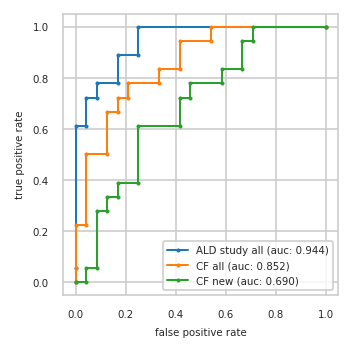

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.611  0.000 0.222  0.042 0.056
3          0.042 0.611  0.042 0.222  0.083 0.056
4          0.042 0.722  0.042 0.500  0.083 0.278
5          0.083 0.722  0.125 0.500  0.125 0.278
6          0.083 0.778  0.125 0.667  0.125 0.333
7          0.167 0.778  0.167 0.667  0.167 0.333
8          0.167 0.889  0.167 0.722  0.167 0.389
9          0.250 0.889  0.208 0.722  0.250 0.389
10         0.250 1.000  0.208 0.778  0.250 0.611
11         1.000 1.000  0.333 0.778  0.417 0.611
12           NaN   NaN  0.333 0.833  0.417 0.722
13           NaN   NaN  0.417 0.833  0.458 0.722
14           NaN   NaN  0.417 0.944  0.458 0.778
15           NaN   NaN  0.542 0.944  0.583 0.778
16           NaN   NaN  0.542 1.000  0.583 0.833
17           NaN   NaN  1.000 1.000  0.667 0.833
18           NaN   NaN    NaN   NaN  0.667 0.944
19           NaN   NaN    NaN   NaN  0.708 0.944
20           NaN   NaN    NaN   NaN  0.708 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,P01011,Q16799
2,B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5,P08670,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
3,P61981,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
4,C9J1I0;C9J2B6;H7BXJ2;Q6UXZ4;Q6UXZ4-2,P15151-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
6,P14174,P14174,J3KSJ8;Q9UD71;Q9UD71-2
7,Q9Y2T3;Q9Y2T3-3,Q14894,P51688
8,P00338;P00338-3,P04075,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


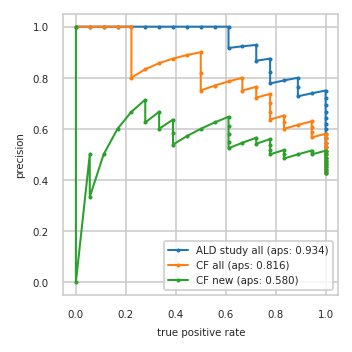

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.720 1.000     0.600 0.833     0.560 0.778
18         0.750 1.000     0.625 0.833     0.542 0.722
19         0.739 0.944     0.652 0.833     0.565 0.722
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.667 0.778     0.524 0.611
22         0.800 0.889     0.700 0.778     0.550 0.611
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.647 0.611
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.800 0.667     0.600 0.500
28         0.929 0.722     0.786 0.611     0.571 0.444
29         0.923 0.667     0.769 0.556     0.538 0.389
30         0.917 0.611     0.750 0.500     0.583 0.389
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


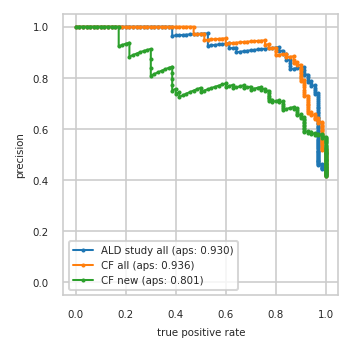

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


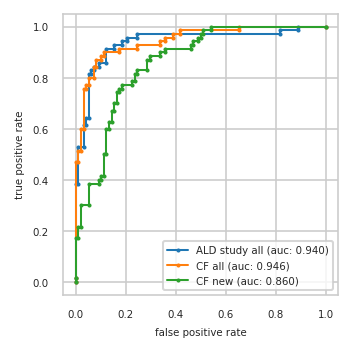

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}